# Tutorial #6: Applying Machine Learning Methods to Temporal Dimensions of EEG Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline

from mne import Epochs, events_from_annotations, pick_types
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.io import concatenate_raws, read_raw_edf

print(__doc__)

# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1.0, 4.0
event_id = dict(hands=2, feet=3)
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)

# Apply band-pass filter
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)
epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2

Automatically created module for IPython interactive environment
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal ba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped


Computing rank from data with rank=None
    Using tolerance 9.7e-05 (2.2e-16 eps * 64 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
  

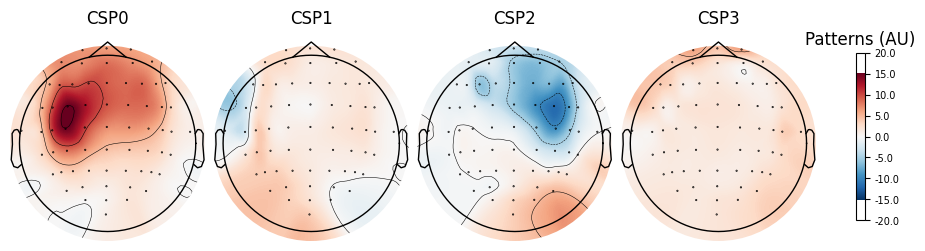

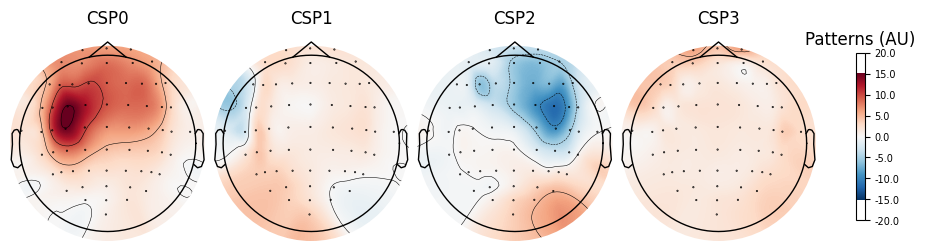

In [2]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data(copy=False)
epochs_data_train = epochs_train.get_data(copy=False)
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([("CSP", csp), ("LDA", lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(
    "Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance)
)

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

Computing rank from data with rank=None
    Using tolerance 9.7e-05 (2.2e-16 eps * 64 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
  

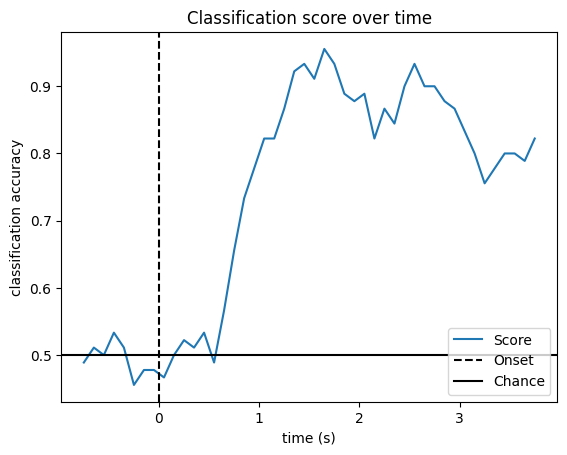

In [3]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()

Adapted from: https://neuro.inf.unibe.ch/AlgorithmsNeuroscience/Tutorial_files/ml.html

Machine Learning Algorithms:

When it comes to classification of EEG data, there are numerous possibilities. One needs to choose:

(a) the type of algorithm that will be used
(b) whether it will be applied in time or space
(c) whether it will be applied at the group or single participant level
Some commonly used algorithms for classifying EEG data are: Support Vector Machines, Linear Discriminant Analysis or Logistic Regression.



These methods will be employed here for demonstrating a simple case of a 2-class classification,
In this tutorial, we will apply classification on the same EEG data as in the previous cases, [Single-Paricipant Analysis](ApplyingMachineLearningMethods_1.ipynb) and [Group-Level Analysis](ApplyingMachineLearningMethods_2.ipynb), but taking advantage of the temporal dimension of the data.

In the previous tutorials ([Single-Paricipant Analysis](ApplyingMachineLearningMethods_1.ipynb) and [Group-Level Analysis](ApplyingMachineLearningMethods_2.ipynb)) we examined whether it is possible to classify EEG responses to different stimuli, at all. However, the classification was agnostic of time. It just informed that somewhere in the brain, at some point in time, there were differential EEG responses to different stimuli (to check).

Here, we go one step further, and ask the questions:
* (a) Can we classify EEG resposnes to different types of motor mental imagery?
* (b) When in time is there discriminant EEG activity?

To answer these questions, we will use the same algorithms as in the previous tutorials ([Single-Paricipant Analysis](ApplyingMachineLearningMethods_1.ipynb) and [Group-Level Analysis](ApplyingMachineLearningMethods_2.ipynb))), but this time, we will train one classifier at each time instance and we will evaluate the performance of the model at each time instance in new epochs. 

First, we will construct a pipeline for classification with the function make_pipeline() of the sklearn library. The steps in this function should be defined in the order of execution.

Before applying a classifier, the function Vectorizer(). The purpose of using Vectorizer is to convert EEG data from (n_epochs, n_channels, n_times) structure to a vector of (samples, channels) form.

Moreover, we will use StandardScaler() to remove the mean and scale to unit variance. StandardScaler standardizes our data feature-wise by the formulation of z = (x - u) / s. In this formula, u is the mean of the feature and s is the standard deviation of the same feature. By applying this technique, each feature's mean and standard deviation will become zero and one respectively. Standardization of features, which are eeg channels in our case, prevent domination of a channel(or a feature) just becuase it contains larger variation.

The final parameter of make_pipeline() will be the machine learning algorithm that we use for classification.

The function [SlidingEstimator](https://mne.tools/dev/generated/mne.decoding.SlidingEstimator.html) in MNE package is provided for this purpose. This takes the model and optionally a scoring function as parameters to create a time-point by time-point classifier. After having created a sliding estimator, it can be fitted to the data, scored the estimator on each task or made predictions on new epochs.

In [4]:
# To silence the warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [5]:
import mne
import matplotlib.pyplot as plt
import numpy as np

from mne.decoding import SlidingEstimator, cross_val_multiscore, Vectorizer, CSP, LinearModel
from mne import Epochs, events_from_annotations, pick_types
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf

from os.path import isfile, join
from os import listdir
import numpy as np
import statistics

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Models
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [6]:
#!pip install mne for google collab

## Analysis on temporal dimensions for each participant separately

# 1. Prepare data for the analysis

In [7]:
print(__doc__)

# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1.0, 4.0
event_id = dict(hands=2, feet=3)
subject_ids = [1,2,3,4,5,6,7,8]
runs = [6, 10, 14]  # motor imagery: hands vs feet

epochs_all, data_all, labels_all = [],[],[]

for id, name in enumerate(subject_ids):
    raw_fnames = eegbci.load_data(name, runs)
    raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
    eegbci.standardize(raw)  # set channel names
    montage = make_standard_montage("standard_1005")
    raw.set_montage(montage)

    # Apply band-pass filter
    raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

    events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

    picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

    # Read epochs (train will be done only between 1 and 2s)
    # Testing will be done with a running classifier
    epochs = Epochs(
        raw,
        events,
        event_id,
        tmin,
        tmax,
        proj=True,
        picks=picks,
        baseline=None,
        preload=True,
    )
    labels = epochs.events[:, -1] - 2
    epochs_data = epochs.get_data(copy=False)
    epochs_all.append(epochs)
    data_all.append(epochs_data)
    labels_all.append(labels) 

Automatically created module for IPython interactive environment
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal ba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 3 contiguous segme

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped


2. Train classifiers with sliding window estimator on data of each participant separately and apply 3-fold cross validation.

in most applications of ML algorithms it is not possible to determine optimal hyperparameters in advance. What is usually done is that we test a range of values for each parameter, and then, select the combination of parameters that give the optimal classification performance.

This is theory can majorly improve classification results. However, if we test each parameter manually, we end up with another issue named overfitting.

In such a case we would train the classifier with training set and test the performance on test set. So, we optimized parameters on the test set. In general, test set is smaller that training set and it may change when the trained classifier is being started to use in real systems. Therefore, having an overfitted model to test set would not provide a good generalization.

For this problem, cross validation would be a solution. In this approach, training set is devided into equally sized folds and trials run on different folds. In this way, hypeparameters will not be optimized on just one dataset, instead different chuncks of data will be used for hyperparameter optimization. Note that, at each trial one fold will be excluded from the training set and excluded fold will be used as test set during evaluation.

In [8]:
def applyCrossValidation(data, labels, epochs, ids, classifier):
    CV_score_time = None
    sl = SlidingEstimator(classifier, scoring='accuracy') 
    if np.isfinite(data).all() == True and np.isnan(data).any() == False:
        CV_score_time = cross_val_multiscore(sl, data, labels, cv=3)
        plotCVScores(epochs.times, CV_score_time, ids)
    else:
        print('Input contains NaN or infinity!')
    return CV_score_time

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

def plotCVScores(times, CV_score_time, id=None):
    fig, ax = plt.subplots()
    if id != None:
        fig.suptitle('CV Scores of Participant-'+str(id))
    else:
        fig.suptitle('CV Scores')  
    ax.plot(times, CV_score_time.T, linewidth = 0.5)
    plt.xlabel('Time')
    plt.ylabel('CV Accuracy')
    plt.show()

### Classification between hand and foot mental imagery

Participant id: 1


100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  319.36it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  353.19it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  339.09it/s]


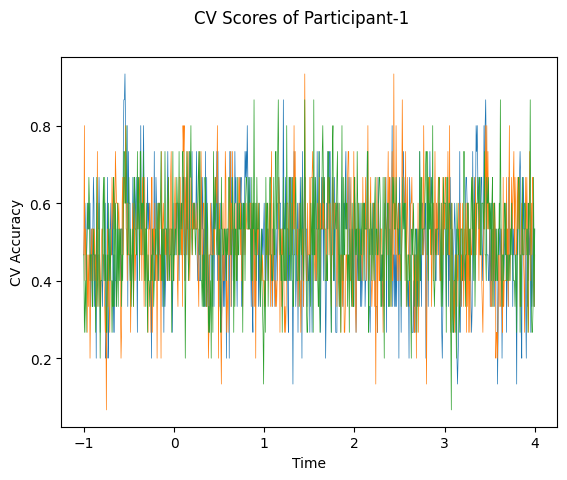

Participant id: 2


100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  354.39it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  334.74it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  357.79it/s]


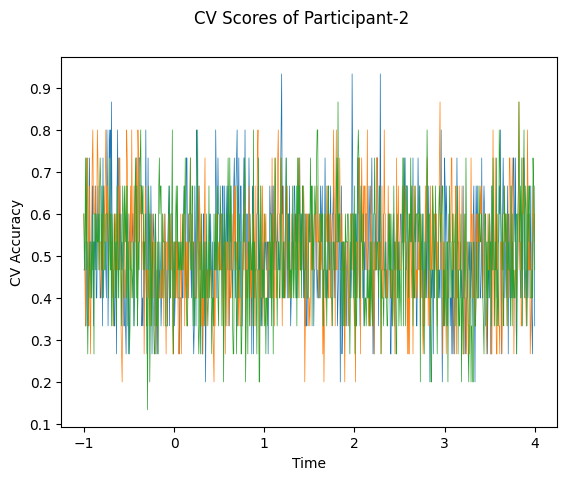

Participant id: 3


100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  354.52it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  350.10it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  368.07it/s]


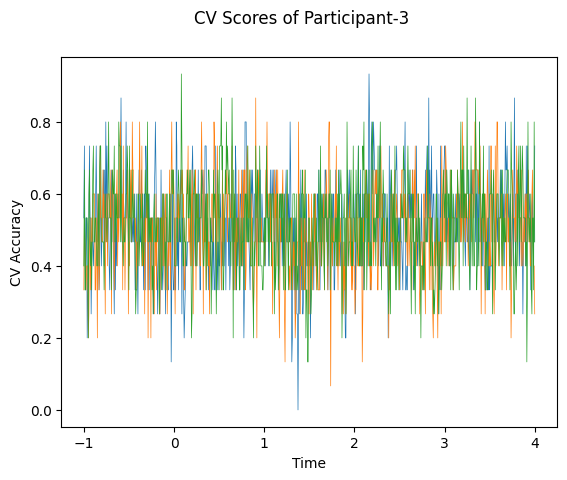

Participant id: 4


100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  362.91it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  323.40it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  382.44it/s]


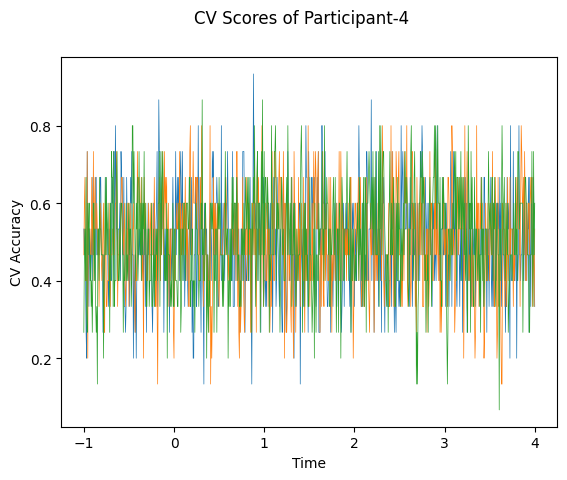

Participant id: 5


100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  376.10it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  377.69it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  367.12it/s]


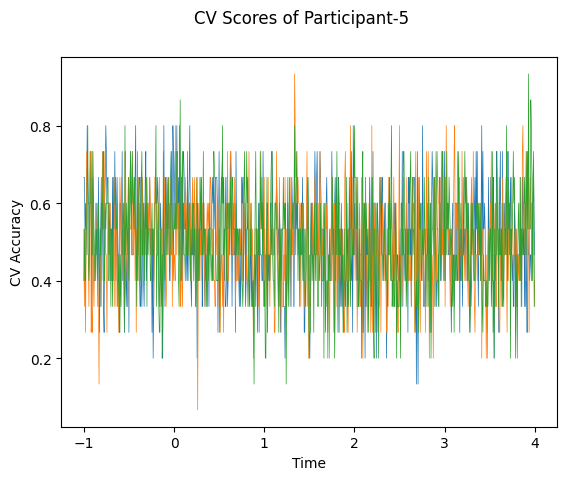

Participant id: 6


100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  376.44it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  369.70it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  369.66it/s]


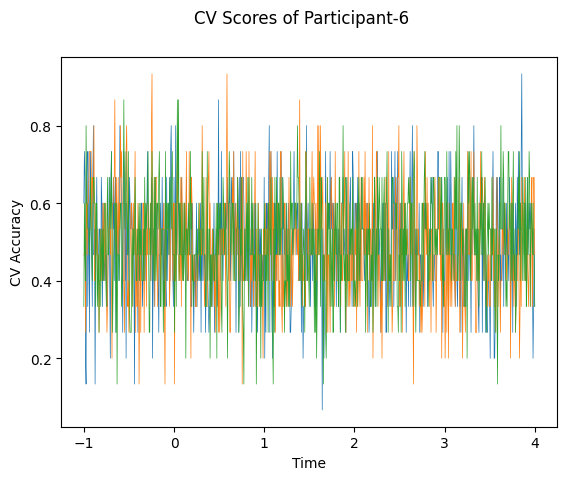

Participant id: 7


100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  380.70it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  378.12it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  377.77it/s]


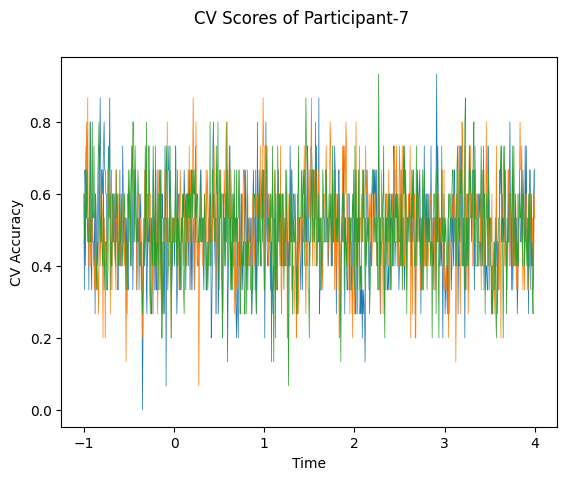

Participant id: 8


100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  354.69it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  368.02it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  364.96it/s]


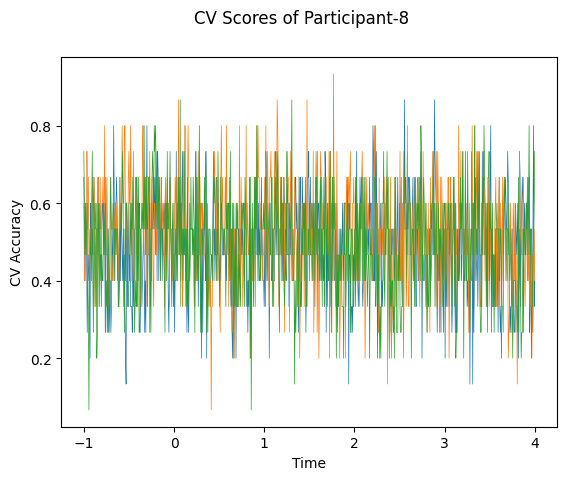

In [10]:
CV_score_time_img = []
for i in range(len(data_all)):
    print('Participant id: '+ str(subject_ids[i]))
    clf = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
    CV_score_time_img.append(applyCrossValidation(data_all[i], labels_all[i], epochs_all[i], subject_ids[i], clf))

In [11]:
def averageCVScores(CV_score_time):
    avg_cv_scores = []
    for cv in CV_score_time:
        avg_scores_tmp = []
        sum_col_wise = cv.sum(axis=0)
        avg_scores_tmp = [s/len(cv) for s in sum_col_wise]
        avg_cv_scores.append(avg_scores_tmp)
    return avg_cv_scores

In [12]:
avg_cv_score_time = averageCVScores(CV_score_time_img)

# The following cell plots the mean and standard deviation of cross validation accuracies of participants.

In [13]:
import pylab, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import ttest_rel, sem

def plot_conditions(data,epochs,labels):

    sns.set(style="white")
    ColorsL = np.array(([228,26,28], [55,126,184], [77,175,74], [152,78,163], [255,127,0]))/256
    col_axes = np.array((82, 82, 82))/256

    al = 0.2
    fig = plt.figure(num=None, figsize=(6, 4), dpi=150)

    
    epochs_mean = np.mean(data, axis = 0)
    epochs_std = sem(data, axis = 0)/2

    plt.plot(epochs[0].times, epochs_mean, color = ColorsL[0], linewidth = 0.75, label = labels)
    plt.axhline(y=0.5, color='b', linestyle='-',label='Chance')
    plt.fill_between(epochs[0].times, epochs_mean, epochs_mean + epochs_std, color = ColorsL[0], interpolate=True, alpha = al)
    plt.fill_between(epochs[0].times, epochs_mean, epochs_mean - epochs_std, color = ColorsL[0], interpolate=True, alpha = al)
    plt.ylabel('Mean CV Accuracy')
    plt.xlabel('Times')

# Mean cross validation accuracy plot below is showing that above chance (50%) accuracy achived at some time points. 

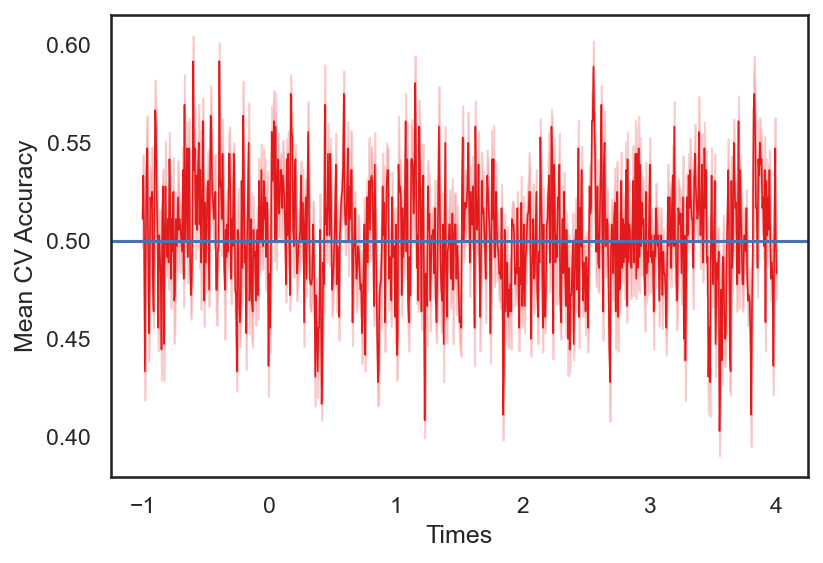

In [14]:
avg_cv_score_time = np.asarray(avg_cv_score_time)
plot_conditions(avg_cv_score_time,epochs_all, labels_all)

# How do you improve the results?

Participant id: 1


100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  370.44it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  370.68it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  372.74it/s]


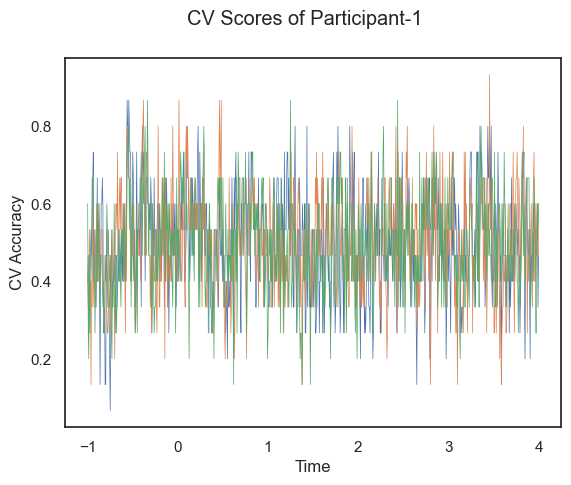

Participant id: 2


100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  380.35it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  362.17it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  380.96it/s]


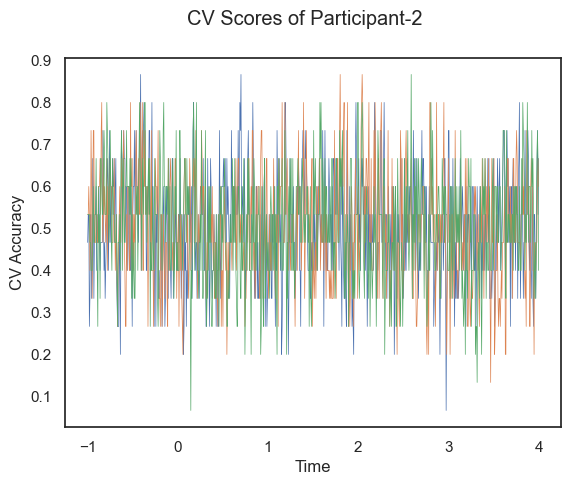

Participant id: 3


100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  399.72it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  387.23it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  399.14it/s]


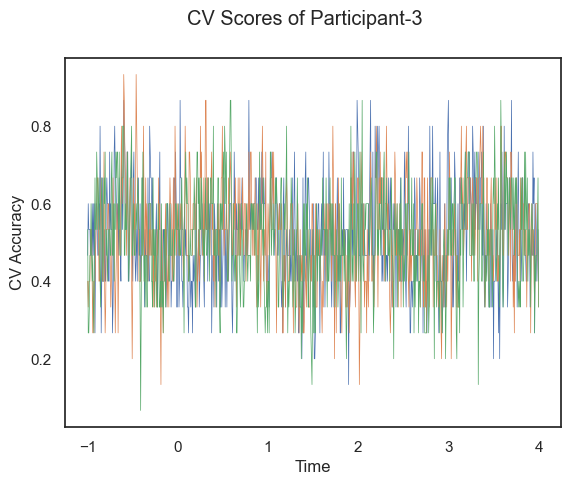

Participant id: 4


100%|████████████| Fitting SlidingEstimator : 801/801 [00:01<00:00,  402.80it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:01<00:00,  400.82it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:01<00:00,  400.70it/s]


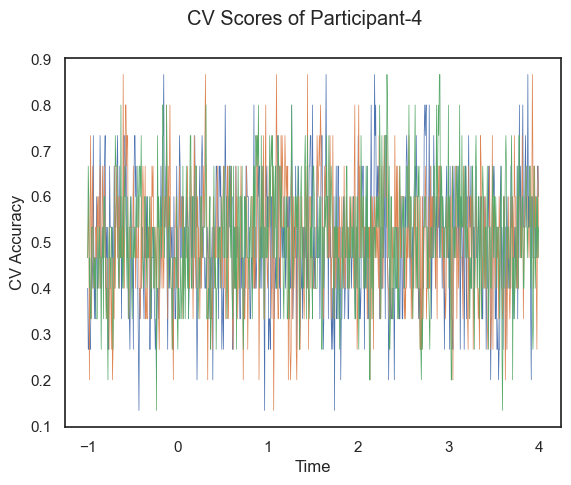

Participant id: 5


100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  396.04it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  397.10it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  359.37it/s]


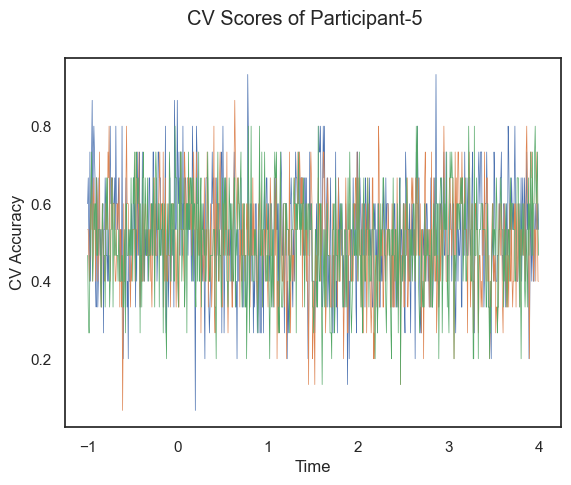

Participant id: 6


100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  393.29it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  362.68it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  368.38it/s]


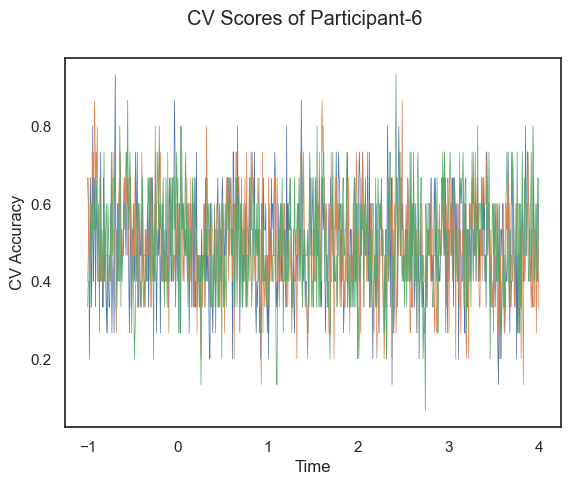

Participant id: 7


100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  379.39it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  368.88it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  387.31it/s]


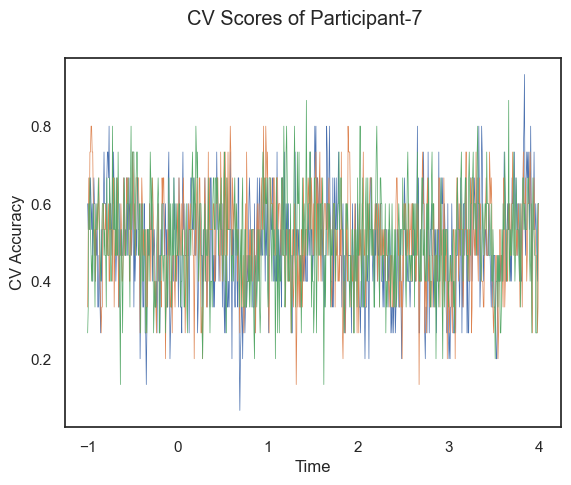

Participant id: 8


100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  368.09it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  395.49it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  399.38it/s]


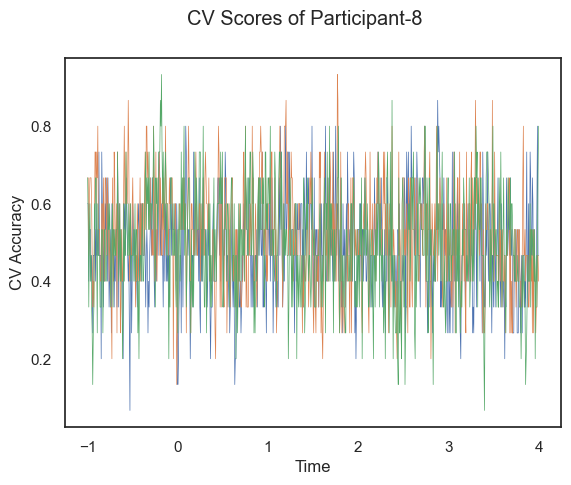

In [15]:
from mne.decoding import LinearModel
CV_score_time_reg = []
for i in range(len(data_all)):
    print('Participant id: '+ str(subject_ids[i]))
    clf_reg = make_pipeline(Vectorizer(), StandardScaler(), LinearModel(LogisticRegression(solver="liblinear")))
    CV_score_time_reg.append(applyCrossValidation(data_all[i], labels_all[i], epochs_all[i], subject_ids[i], clf_reg))

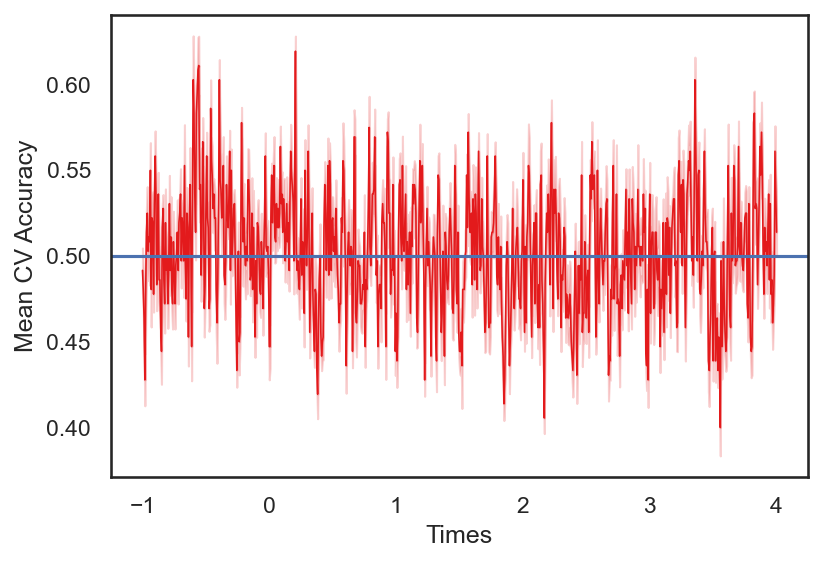

In [16]:
avg_cv_score_time_reg = averageCVScores(CV_score_time_reg)
plot_conditions(avg_cv_score_time_reg,epochs_all, labels_all)

# Decode the full epoch

In [17]:
def applyCrossValidation(data, labels, epochs, ids, classifier):
    CV_score = None
    if np.isfinite(data).all() == True and np.isnan(data).any() == False:
        CV_score= cross_val_multiscore(classifier, data, labels, cv=3)
        print(CV_score)
    else:
        print('Input contains NaN or infinity!')
    return CV_score

In [19]:
CV_scores= []
for i in range(len(data_all)):
    print('Participant id: '+ str(subject_ids[i]))    
    #clf = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(solver="liblinear"))
    clf = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
    CV_scores.append(applyCrossValidation(data_all[i], labels_all[i], epochs_all[i], subject_ids, clf))
    print(np.mean(CV_scores))

Participant id: 1
[0.46666667 0.6        0.46666667]
0.5111111111111111
Participant id: 2
[0.53333333 0.33333333 0.4       ]
0.4666666666666666
Participant id: 3
[0.53333333 0.53333333 0.66666667]
0.5037037037037037
Participant id: 4
[0.2        0.53333333 0.46666667]
0.4777777777777778
Participant id: 5
[0.6        0.6        0.53333333]
0.4977777777777777
Participant id: 6
[0.46666667 0.46666667 0.53333333]
0.4962962962962963
Participant id: 7
[0.4        0.6        0.46666667]
0.49523809523809526
Participant id: 8
[0.46666667 0.73333333 0.33333333]
0.49722222222222223
